In [74]:
import cv2
import os
import numpy as np
from segment_anything import SamPredictor, sam_model_registry
import torch
import matplotlib.pyplot as plt
from PIL import Image
from video_mask_compose import overlay_masks_on_video 

In [32]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [33]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda:0"

In [34]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)


In [334]:
# Load first frame from video
video_id = "1888"
video_path = f"/data/zixuan/sthsthv2/Unfolding_something/{video_id}.webm"
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if not ret:
    print("Failed to read the video")
image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

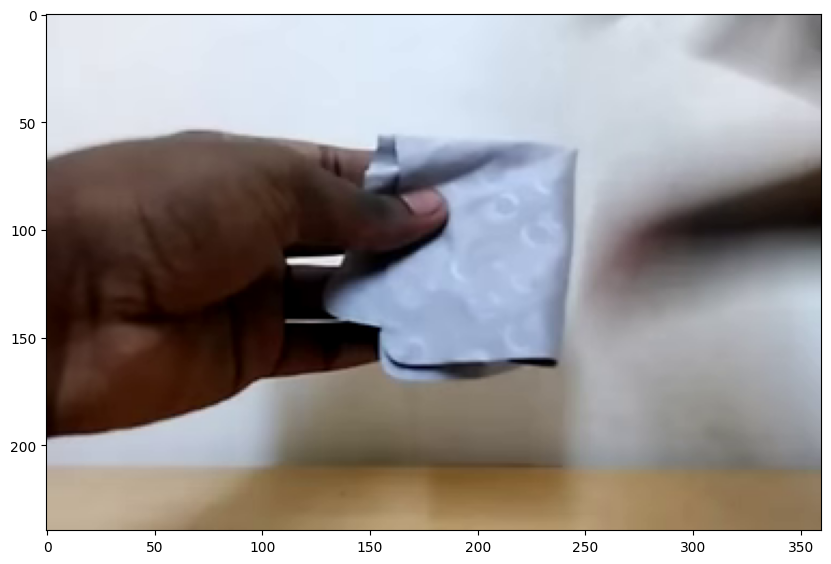

In [335]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [336]:
# Generate segmentation mask
predictor.set_image(image)

In [328]:
input_point = np.array([[300, 200],[400, 50], [100, 100]])
input_label = np.array([1, 0, 0])

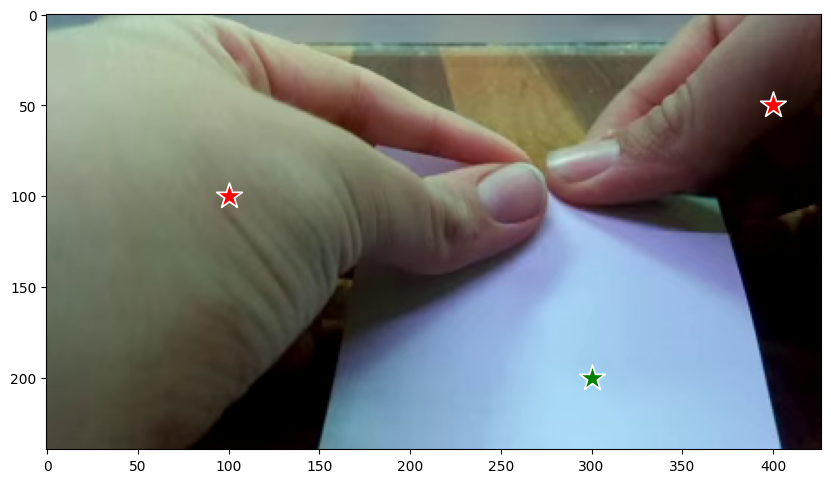

In [329]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [330]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

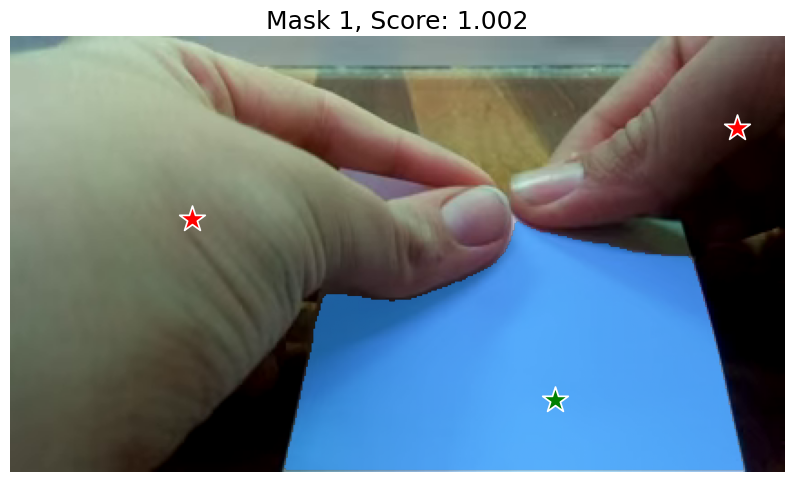

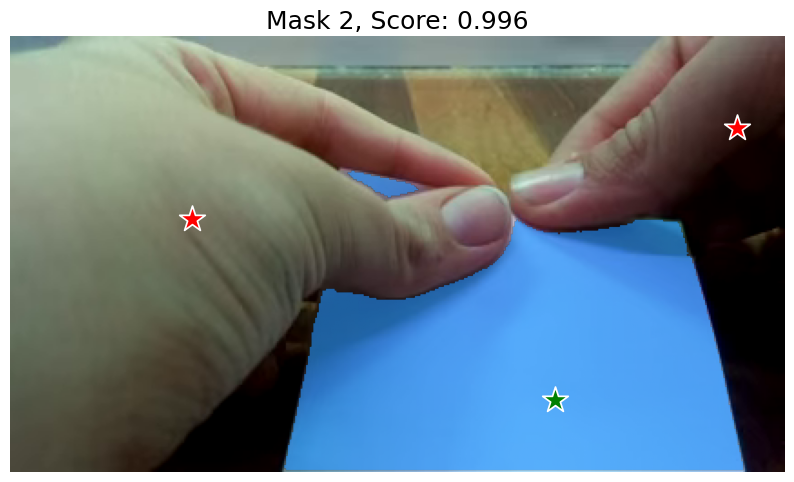

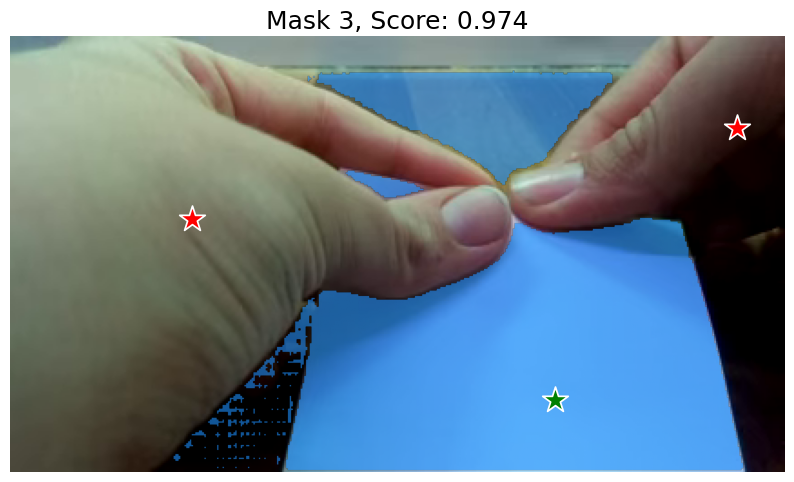

In [331]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [332]:
best_choice = 1
h, w = mask.shape[-2:]
mask = masks[best_choice].reshape(h, w)
img_mask = Image.fromarray(mask, mode="L")
mask_dir = os.path.join("/home/chenzixuan/myVOS/mask_dir/", video_id)
if not os.path.exists(mask_dir):
    os.mkdir(mask_dir)
img_mask.save(os.path.join((mask_dir), "00000.png"))
video_id

'13653'

In [333]:

masks_folder = f'/home/chenzixuan/myVOS/output_dir/{video_id}'
output_path = f'/home/chenzixuan/myVOS/{video_id}.mp4'
overlay_masks_on_video(video_path, masks_folder, output_path)